In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    LandmarkLagrangianProcess, LandmarkLagrangianAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLP, MLPSmall
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_landmark_sample_path

In [3]:
def ellipse(n_landmarks: int, a: float = 1.0, b: float = 1.0, rotation: float = 0.0, shift_x: float = 0.0, shift_y: float = 0.0):
    u = jnp.linspace(0.0, 2.0*jnp.pi, num=n_landmarks, endpoint=False)
    x = a * jnp.sin(u)
    y = b * jnp.cos(u)
    x_rot = x * jnp.cos(rotation) - y * jnp.sin(rotation) 
    y_rot = x * jnp.sin(rotation) + y * jnp.cos(rotation)
    x_shift = x_rot + shift_x
    y_shift = y_rot + shift_y
    u = jnp.stack([x_shift, y_shift], axis=-1)
    return u

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


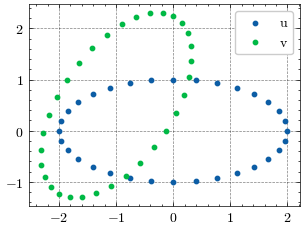

In [4]:
n_landmarks = 32        # number of landmarks
m_landmarks = 2         # number of dimensions per landmark
dim = n_landmarks * m_landmarks

T = 1.0
dt = 1. / 100
dtype = jnp.float32

k_alpha = 0.3
k_sigma = 1.0

seed = 42

u = ellipse(n_landmarks=32, a=2.0, b=1.0, rotation=0.0).flatten()
v = ellipse(n_landmarks=32, a=2.0, b=1.0, rotation=jnp.pi/3, shift_x=-1.0, shift_y=0.5).flatten()
plt.scatter(u.reshape(-1, 2)[:, 0], u.reshape(-1, 2)[:, 1], s=10, label="u")
plt.scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v")
plt.legend()

In [5]:
t_scheme = "quadratic"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc = LandmarkLagrangianProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc = LandmarkLagrangianAuxProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc.init_g(x0=u)
# aux_proc.g0 = k_alpha * jnp.eye(dim, dtype=dtype)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)

In [6]:
ori_path = ori_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
aux_path = aux_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-3,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

guided_path = guided_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=v)

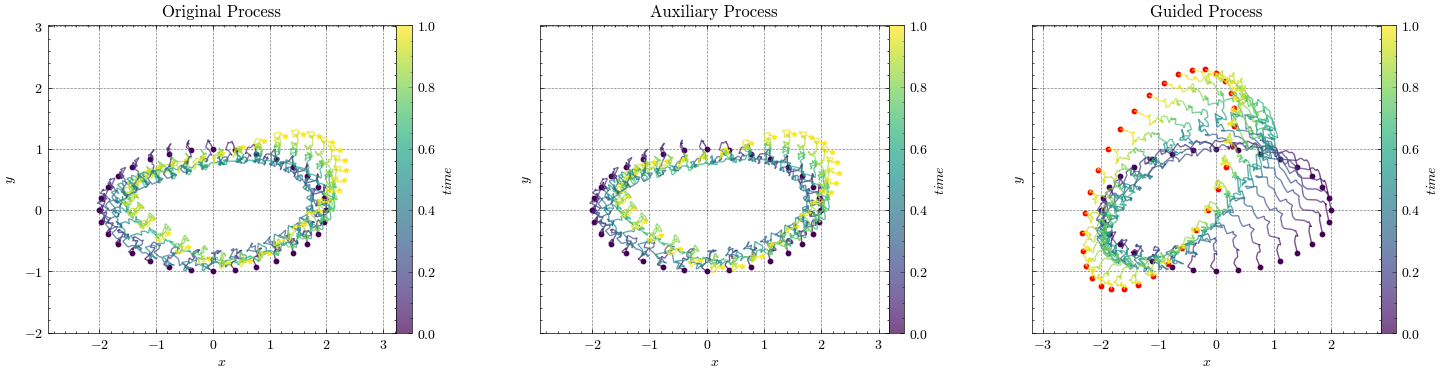

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
plot_landmark_sample_path(ori_path[1], m_landmarks, ax=ax[0], cmap="viridis", scatter_size=10, title="Original Process")
plot_landmark_sample_path(aux_path[1], m_landmarks, ax=ax[1], cmap="viridis", scatter_size=10, title="Auxiliary Process")
plot_landmark_sample_path(guided_path[1], m_landmarks, ax=ax[2], cmap="viridis", scatter_size=10, title="Guided Process")
ax[2].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')


In [8]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(64, 64, 64, 64),
    activation="tanh",
    norm=None
)

In [12]:
train_config = {
    "save_name": "landmarks_circle_2e-1alpha_8e-1sigma",
    "seed": seed,
    "learning_rate": 1e-4,
    "batch_size": 16,
    "n_iters": 500,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [13]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)

In [14]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/500 [00:00<?, ?iter/s]

KeyboardInterrupt: 

In [12]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

In [9]:
pCN_config = {
    "seed": seed,
    "rho": 0.99,
    "batch_size": 4,
    "n_iters": 2500
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN()

Running for 2,500 iterations:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 12.87%


Text(0, 0.5, 'Log-likelihood')

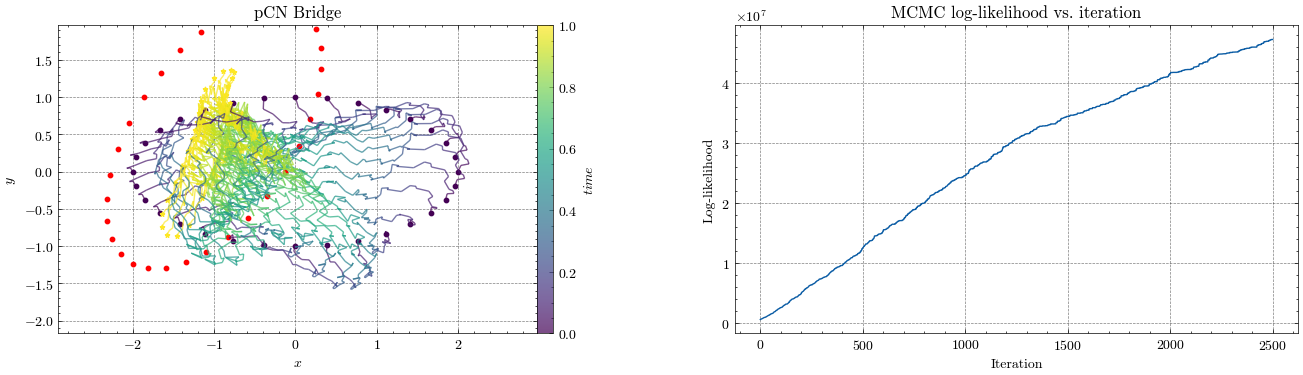

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_landmark_sample_path(pCN_result.path[0], m_landmarks, ax=ax[0], cmap="viridis", title="pCN Bridge", scatter_size=10)
ax[0].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')

ax[1].plot(jnp.mean(pCN_result.log_lls, axis=1))
ax[1].set_title("MCMC log-likelihood vs. iteration")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Log-likelihood")

In [14]:
sm_train_config = {
    "save_name": "landmarks_circle_1e-1alpha_5e-1sigma",
    "seed": seed,
    "learning_rate": 1e-4,
    "batch_size": 16,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [15]:
neural_net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 32, 32, 32),
    norm="batch",
    t_emb_dim=32,
    t_emb_max_period=200.0,
    t_emb_scaling=100.0
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/landmarks_circle_1e-1alpha_5e-1sigma
INFO:root:Loading pretrained model from the last epoch


In [16]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=u)

Text(0.5, 0.98, 'Landmark model, guided by standard brownian process')

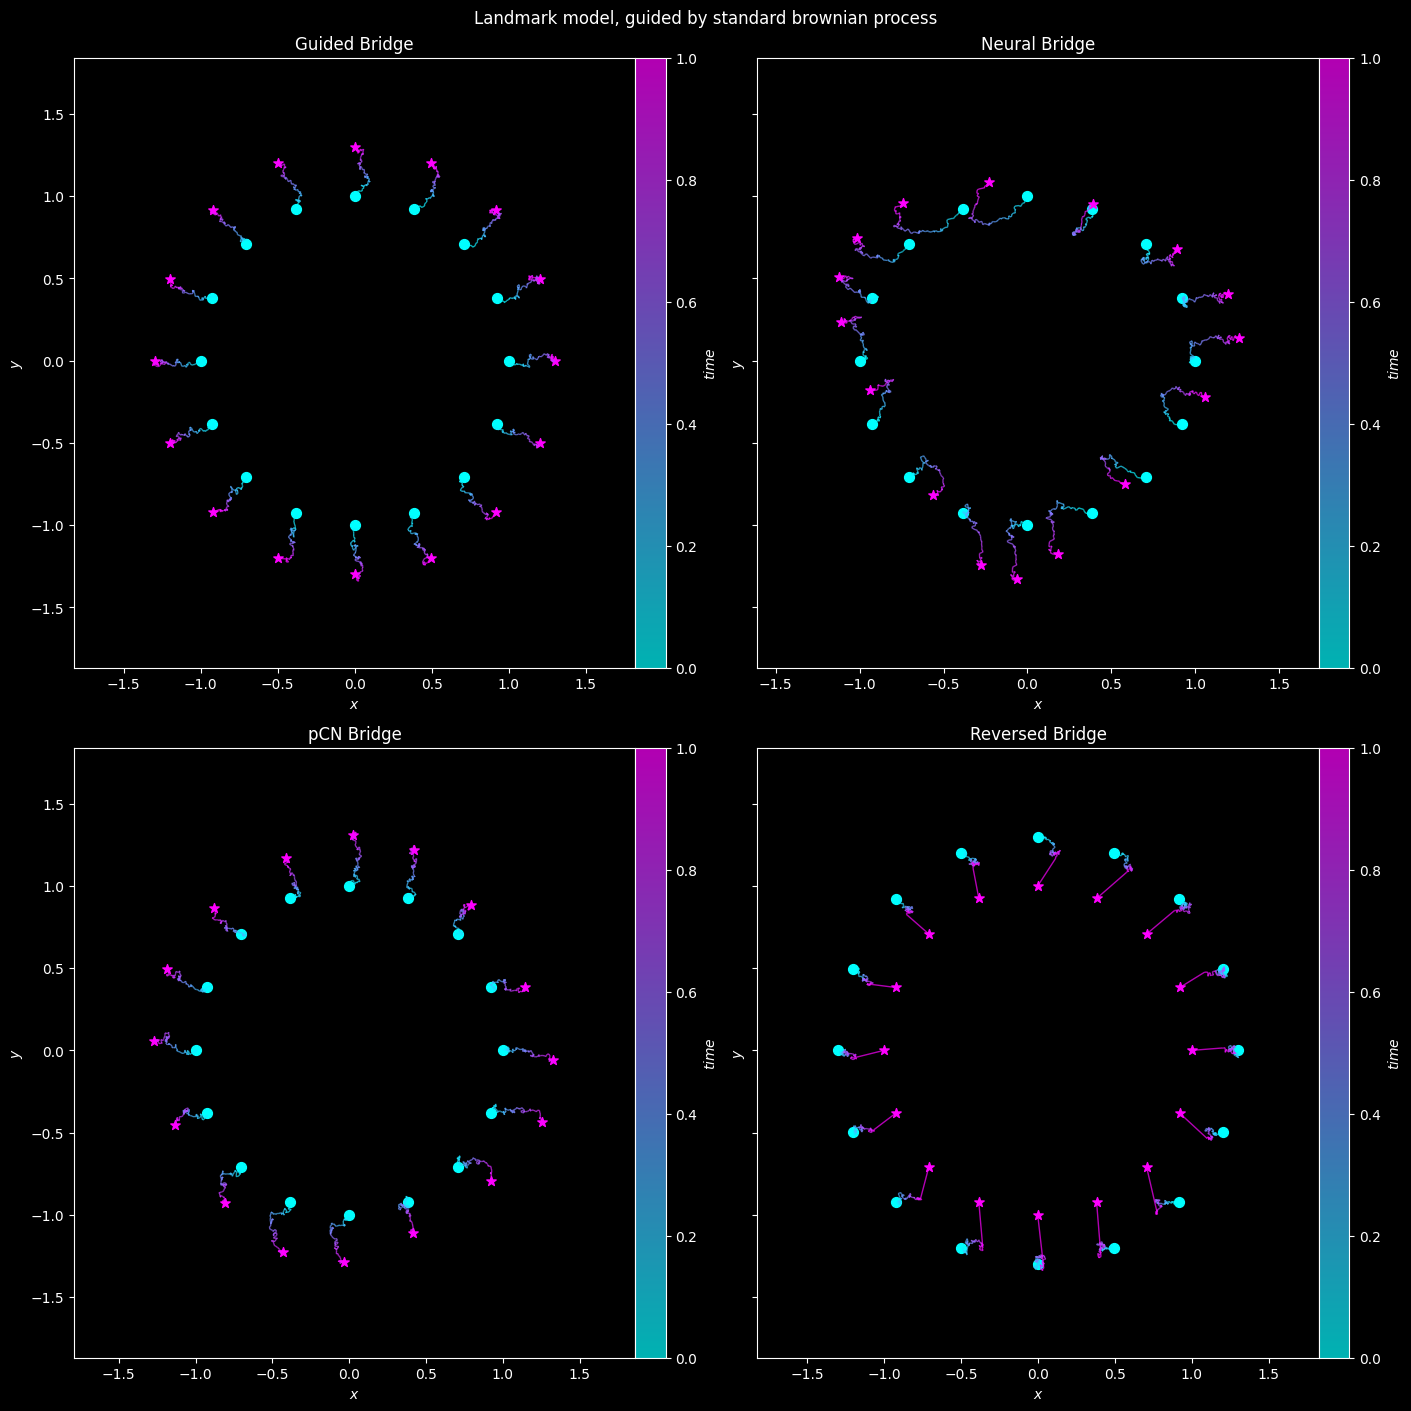

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), layout="constrained", sharey=True)
plot_landmark_sample_path(guided_path[1], m_landmarks, ax=ax[0, 0], cmap="cool", title="Guided Bridge")
plot_landmark_sample_path(neural_bridge_path[1], m_landmarks, ax=ax[0, 1], cmap="cool", title="Neural Bridge")
plot_landmark_sample_path(pCN_result.path_X[1], m_landmarks, ax=ax[1, 0], cmap="cool", title="pCN Bridge")
plot_landmark_sample_path(reversed_bridge_path[1], m_landmarks, ax=ax[1, 1], cmap="cool", title="Reversed Bridge")
fig.suptitle("Landmark model, guided by standard brownian process")